# Isine Tile Grid

In [1]:
%matplotlib widget
import numpy
import shapely.geometry
import geopandas
import pyproj
import matplotlib.pyplot as plt
import contextily
import pystare
import starepandas
import shapely
import pickle
import pandas
import sqlalchemy
import time
import postgis
import cartopy

In [2]:
sinu_wkt = '''  PROJCRS["MODIS Sinusoidal",
                    BASEGEOGCRS["",
                        DATUM["unnamed", ELLIPSOID["WGS 84",6371007.181,0,LENGTHUNIT["metre",1]]],
                        PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]]],
                CONVERSION["",
                    METHOD["Sinusoidal"],
                    PARAMETER["semi_major",6371007.181],
                    PARAMETER["semi_minor",6371007.181]],
                CS[Cartesian,2],
                    AXIS["(E)",east,ORDER[1],LENGTHUNIT["m",1]],
                    AXIS["(N)",north,ORDER[2],LENGTHUNIT["m",1]]]'''

sinu_crs = pyproj.crs.CRS(sinu_wkt)
wgs84 = pyproj.CRS('EPSG:4326')

In [3]:
r = 6371007.181

def lonlat2xy(lon, lat):
    y = lat * r *(numpy.pi/180)
    x = lon * r * (numpy.cos(numpy.deg2rad(lat))) * (numpy.pi/180)
    return x, y

def xy2lonlat(x, y):
    lat = y / r / (numpy.pi/180)
    lon = x / r / (numpy.cos(numpy.deg2rad(lat))) / (numpy.pi/180)
    return lon, lat

# Make Tiles

In [4]:
h = 0
x_res = 10
y_res = 10

tiles =[]
for x in (numpy.arange(-90, 90, 10) + 5):
    v=0
    for y in (numpy.arange(-180, 180, 10) + 5):
        cell = {}
        box  = shapely.geometry.Polygon([(x-x_res/2, y-y_res/2), 
                                         (x+x_res/2, y-y_res/2),
                                         (x+x_res/2, y+y_res/2),
                                         (x-x_res/2, y+y_res/2), 
                                         (x-x_res/2, y-y_res/2)])
        center = shapely.geometry.Point(x, y)   
        cell['box'] = box
        cell['center'] = center
        cell['h'] = h        
        cell['v'] = v        
        tiles.append(cell)
        v+=1
    h+=1

tiles = geopandas.GeoDataFrame(tiles, geometry='box', crs=wgs84)

In [5]:
delta_v = (180 * r * (numpy.pi/180))/18
delta_h = (360 * r * (numpy.pi/180))/36

_, top = lonlat2xy(0, 90)
_, bottom = lonlat2xy(0, -90)
left, _ = lonlat2xy(-180, 0)
right, _ = lonlat2xy(180, 0)

x_res = (left-right)/36
y_res = (bottom-top)/18

In [6]:
h = 0
tiles = []
for x in (numpy.arange(left, right, delta_h) + delta_h/2):
    v=0
    for y in (numpy.arange(top, bottom, -delta_v) - delta_v/2):
        tile = {}
        box  = shapely.geometry.Polygon([(x-x_res/2, y-y_res/2), 
                                         (x+x_res/2, y-y_res/2),
                                         (x+x_res/2, y+y_res/2),
                                         (x-x_res/2, y+y_res/2), 
                                         (x-x_res/2, y-y_res/2)])
        center = shapely.geometry.Point(x, y)   
        tile['box'] = box
        tile['center'] = center
        tile['h'] = h        
        tile['v'] = v        
        tiles.append(tile)
        v+=1
    h+=1

tiles = geopandas.GeoDataFrame(tiles, geometry='box', crs=sinu_crs)

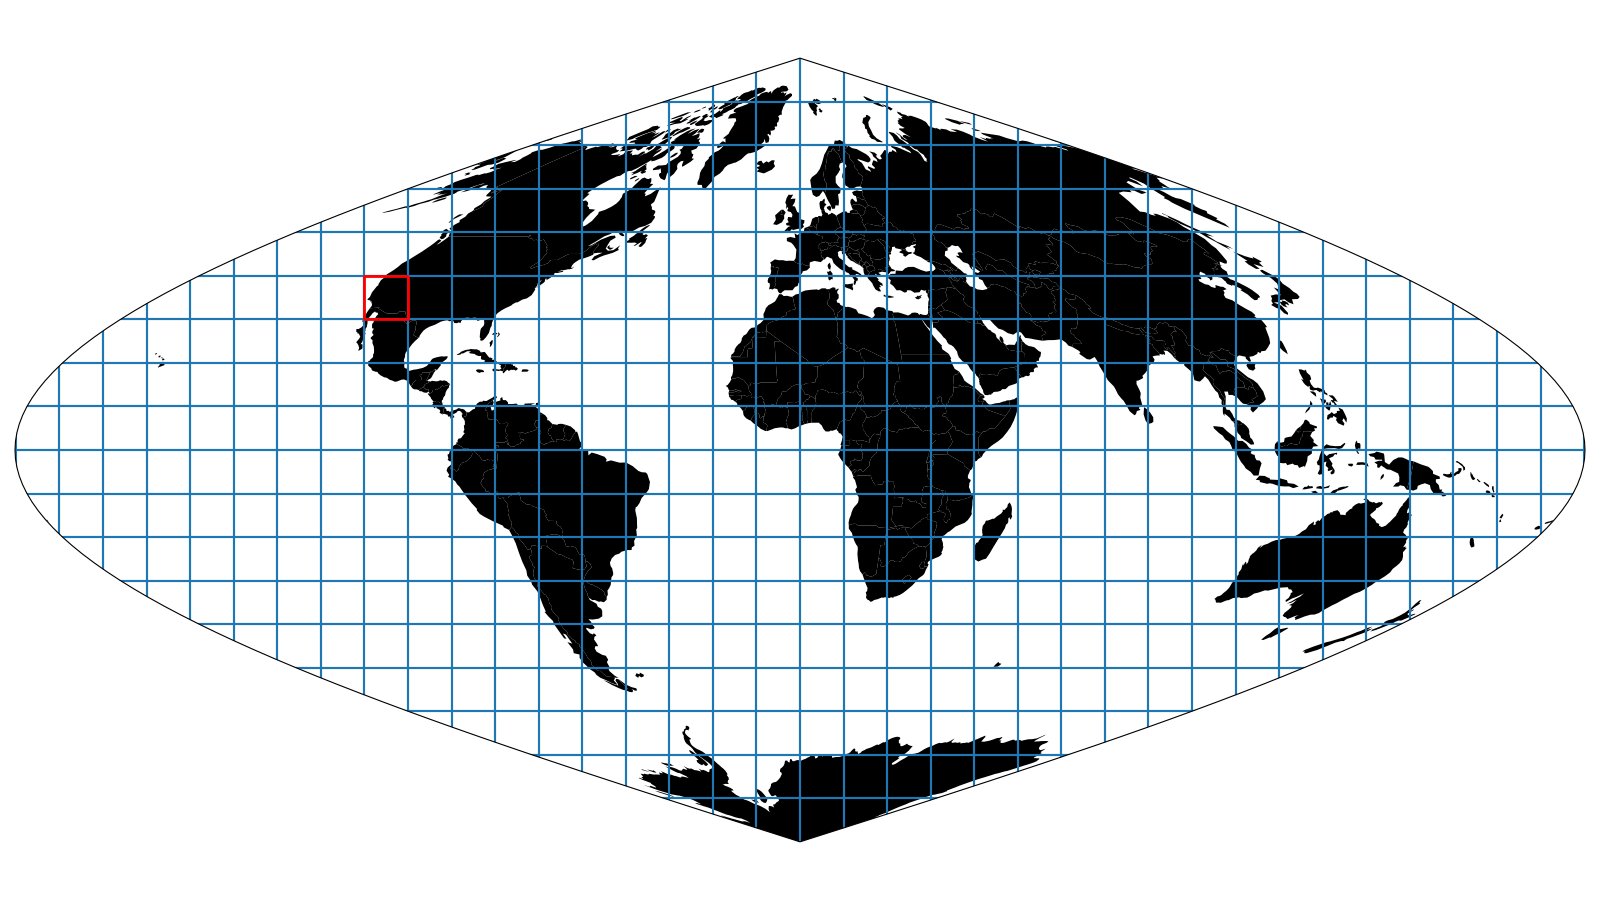

In [7]:
proj=cartopy.crs.Sinusoidal()

opts = {'projection': proj}

fig, ax = plt.subplots(figsize=(16,9), dpi=100, subplot_kw=opts)
#fig, ax = plt.subplots(figsize=(10,5), dpi=100)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.to_crs(sinu_crs).plot(ax=ax, zorder=1, color='black')
#ax.coastlines()

tiles.exterior.plot(ax=ax, zorder=2)
tile = tiles[(tiles.h==8)& (tiles.v==5)]
tile.exterior.plot(ax=ax, color='red', zorder=3, linewidth=2)
fig.tight_layout()

<AxesSubplot:>

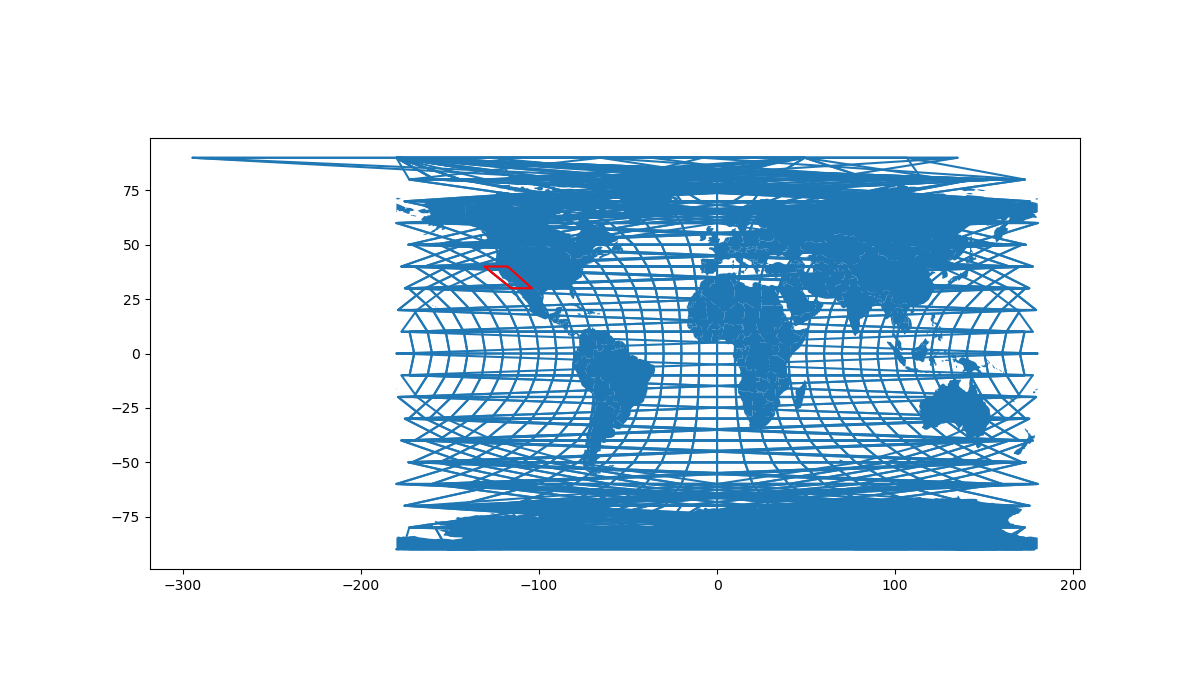

In [8]:
fig = plt.figure(figsize=(12, 7), dpi=100)
ax = fig.add_subplot()

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, zorder=3)
tiles.to_crs(4326).exterior.plot(ax=ax, zorder=2)
tile = tiles[(tiles.h==8)& (tiles.v==5)]
tile.to_crs(4326).exterior.plot(ax=ax, color='red', zorder=3)

In [9]:
tiles.set_geometry('box')[['box','h', 'v']].to_file('data/tilegrid.gpkg', driver='GPKG')

# Create Cells for a tile

In [10]:
h = 8
v = 5

In [11]:
west = -180 + h * 10
east = west+10
north = 90 - v * 10
south = north-10

_, top = lonlat2xy(0, north)
_, bottom = lonlat2xy(0, south)
left, _ = lonlat2xy(west, 0)
right, _ = lonlat2xy(east, 0)

height = width = size = 2400
x_res = y_res = res = (right-left)/size
res

463.3127165693852

In [12]:
x_sinu = numpy.tile(numpy.arange(left, right, res), (height, 1)) + res/2
y_sinu = numpy.tile(numpy.arange(top, bottom, -res), (width, 1)).T - res/2

x_array = numpy.tile(numpy.arange(0, width, 1), (height, 1))
y_array = numpy.tile(numpy.arange(0, width, 1), (height, 1)).T


# Small
x_min = 1353
x_max = 1402
y_min = 552
y_max = 575

# Big
x_min = 1346
x_max = 1427
y_min = 535
y_max = 578

# Huge
x_min = 1294
x_max = 1430
y_min = 532
y_max = 619

bbox = (x_min, x_max, y_min, y_max)

subset = True
if subset:
    # Careful!! First axis is now y
    x_sinu = x_sinu[y_min:y_max+1, x_min:x_max+1]
    y_sinu = y_sinu[y_min:y_max+1, x_min:x_max+1]

    x_array = x_array[y_min:y_max+1, x_min:x_max+1]
    y_array = y_array[y_min:y_max+1, x_min:x_max+1]

# Centers

## Sinu

In [13]:
centers_sinu = geopandas.points_from_xy(x_sinu.flatten(), y_sinu.flatten(), crs=sinu_crs)
centers_sinu = geopandas.GeoSeries(centers_sinu, crs=sinu_crs)

## WGS84

In [14]:
lon, lat = xy2lonlat(x_sinu, y_sinu)
centers_4326 = geopandas.points_from_xy(lon.flatten(), lat.flatten(), crs='EPSG:4326')
centers_4326 = geopandas.GeoSeries(centers_4326, crs='EPSG:4326')

## SIDS

In [15]:
n_partitions = 200

In [16]:
lat = numpy.ascontiguousarray(lat)
lon = numpy.ascontiguousarray(lon)
centers_sids = pystare.from_latlon_2d(lat, lon, adapt_level=True)
centers_sids = pandas.Series(centers_sids.flatten())

In [17]:
pystare.spatial_resolution(centers_sids).min()

14

## Trixels

In [18]:
centers_trixels = starepandas.trixels_from_stareseries(centers_sids, n_partitions=n_partitions)

# Covers

## Sinu

In [19]:
polygons_sinu = []
for x, y in zip(x_sinu.flatten(), y_sinu.flatten()):    
    cell = shapely.geometry.polygon.Polygon([(x-x_res/2, y-y_res/2), 
                                             (x+x_res/2, y-y_res/2),
                                             (x+x_res/2, y+y_res/2),
                                             (x-x_res/2, y+y_res/2), 
                                             (x-x_res/2, y-y_res/2)] )
    polygons_sinu.append(cell)
polygons_sinu = geopandas.GeoSeries(polygons_sinu, crs=sinu_crs)

## WGS48

In [20]:
polygons_4326 = polygons_sinu.to_crs('EPSG:4326')

## SIDS

In [21]:
sids_cover_levels = [15, 16, 17, 18, 19, 20]
sids_covers = {}
for level in sids_cover_levels:
    print(level)
    sids = starepandas.sids_from_geoseries(polygons_4326, level=level, n_partitions=n_partitions, convex=True)
    sids = pandas.Series(sids)
    sids_covers[f'sids_covers_{level}'] = sids

15
16
17
18
19
20


## Trixels

In [22]:
trixels_covers = {}
for level in sids_cover_levels:    
    print(level)
    sids = sids_covers[f'sids_covers_{level}']
    trixels = starepandas.trixels_from_stareseries(sids, n_partitions=n_partitions)
    trixels_covers[f'trixels_covers_{level}'] = trixels

15
16
17
18
19
20


# Buffers

## WGS 4326

In [23]:
polygons_3310 = polygons_sinu.to_crs(3310)
buffer_distances = [250, 500, 1000]
buffers = {}

for distance in buffer_distances:    
    buffers[f'buffer_{distance}'] = polygons_3310.buffer(250).to_crs(4326)

## SIDS

In [24]:
sids_buffers = {}

for distance in buffer_distances:
    print(distance)
    buffer = buffers[f'buffer_{distance}']
    sids = starepandas.sids_from_geoseries(buffer, level=17, n_partitions=n_partitions, convex=True)
    sids = pandas.Series(sids)
    sids_buffers[f'buffer_sids_{distance}'] = sids    

250
500
1000


## Trixels

In [25]:
trixels_buffers = {}

for distance in buffer_distances:
    sids = sids_buffers[f'buffer_sids_{distance}'] 
    trixels_buffers[f'buffer_trixels_{distance}'] = starepandas.trixels_from_stareseries(sids, n_partitions=n_partitions)

# Plots

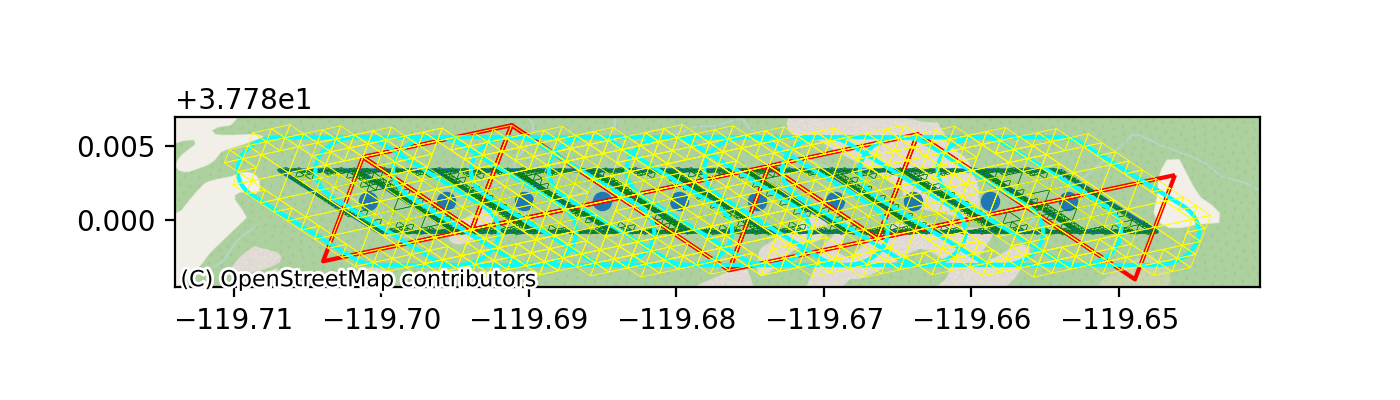

In [26]:
fig = plt.figure(figsize=(7, 2), dpi=200)
ax = fig.add_subplot()

polygons_4326[0:10].exterior.plot(ax=ax)
centers_4326[0:10].plot(ax=ax)
centers_trixels.exterior[0:10].plot(ax=ax, color='r')
trixels_covers['trixels_covers_19'][0:10].boundary.plot(ax=ax, linewidth=0.2, color='green')
buffers['buffer_250'][0:10].exterior.plot(ax=ax, color='cyan')
trixels_buffers['buffer_trixels_250'][0:10].boundary.plot(ax=ax, color='yellow', linewidth=0.3)

contextily.add_basemap(ax, crs=4326, source=contextily.providers.OpenStreetMap.Mapnik)

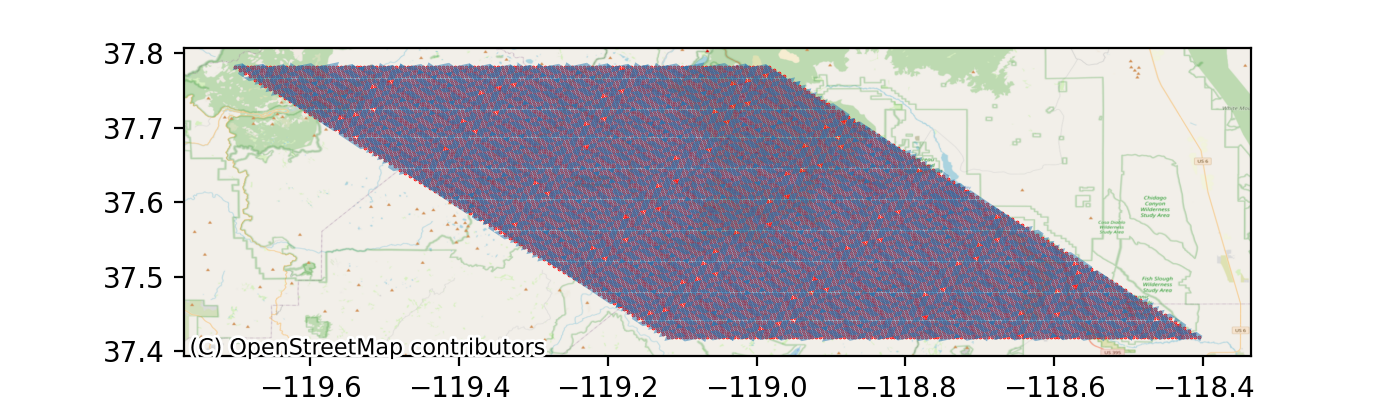

In [27]:
fig = plt.figure(figsize=(7, 2), dpi=200)
ax = fig.add_subplot()

centers_4326.plot(ax=ax, alpha=1, markersize=0.1, color='red')
centers_trixels.plot(ax=ax, alpha=0.5, linewidth=0.5)

contextily.add_basemap(ax, crs=4326, source=contextily.providers.OpenStreetMap.Mapnik)

# Merging

In [28]:
x_array.flatten()

array([1294, 1295, 1296, ..., 1428, 1429, 1430])

In [29]:
cells = {'x': x_array.flatten(),
         'y': y_array.flatten(),
         'x_sinu': x_sinu.flatten(), 
         'y_sinu': y_sinu.flatten(), 
         'lat': lat.flatten(), 
         'lon': lon.flatten(),          
         'centers_sinu': centers_sinu,
         'centers_4326': centers_4326,
         'centers_sids': centers_sids,
         'centers_trixels': centers_trixels,
         'polygons_sinu': polygons_sinu,
         'polygons_4326': polygons_4326,         
         **sids_covers,
         **trixels_covers,
         **buffers,         
         **sids_buffers,
         **trixels_buffers,}

In [30]:
cells = pandas.DataFrame(data=cells)

# Upload

In [31]:
user = 'spires_rw'
pwd = 'spiresrw'
host= 'localhost'
db_name = 'spires'
uri = f'postgresql+psycopg2://{user}:{pwd}@{host}/{db_name}'

engine = sqlalchemy.create_engine(uri)

In [32]:
import postgis
import importlib
importlib.reload(postgis)

<module 'postgis' from '/home/griessbaum/modfootprint/postgis.py'>

In [33]:
postgis.write(cells, engine)

In [34]:
with engine.connect() as con:
    con.execute('CREATE INDEX IF NOT EXISTS x ON public.cells USING btree (x ASC NULLS LAST);')
    con.execute('CREATE INDEX IF NOT EXISTS y ON public.cells USING btree (y ASC NULLS LAST);')
    con.execute('CREATE INDEX IF NOT EXISTS centers_sids ON cells USING btree (centers_sids ASC NULLS LAST);')

# Test reading back

In [35]:
df = postgis.read('cells', engine)

<AxesSubplot:>

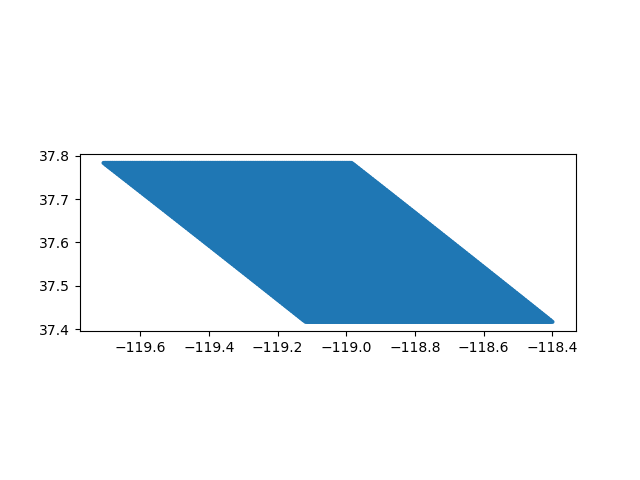

In [36]:
df.set_geometry('buffer_250').exterior.plot()

# Compare to mod09ga

In [37]:
import modreaders
import starepandas

file_path = '/tablespace/spires/mod09ga/MOD09GA.A2017345.h08v05.006.2017347024314.hdf'
mod09ga = starepandas.io.granules.Mod09GA(file_path, sidecar_path='data/h08v05_stare.nc')
mod09ga.read_sidecar_latlon()
mod09ga = mod09ga.to_df(xy=True)

In [38]:
subset = mod09ga[(mod09ga.x>=x_min) &(mod09ga.x<=x_max) &(mod09ga.y>=y_min)&(mod09ga.y<=y_max)]
subset

,lat,lon,x,y
1278094,37.781250,-119.700874,1294,532
1278095,37.781250,-119.695602,1295,532
1278096,37.781250,-119.690331,1296,532
1278097,37.781250,-119.685059,1297,532
1278098,37.781250,-119.679787,1298,532
...,...,...,...,...
1487026,37.418751,-118.426567,1426,619
1487027,37.418751,-118.421318,1427,619
1487028,37.418751,-118.416069,1428,619
1487029,37.418751,-118.410828,1429,619


In [39]:
df[['x', 'y', 'lat', 'lon', 'centers_sids']]

,x,y,lat,lon,centers_sids
0,1294,532,37.78125,-119.700875,3330973285452204238
1,1295,532,37.78125,-119.695603,3330973271079171886
2,1296,532,37.78125,-119.690331,3330973274715543854
3,1297,532,37.78125,-119.685059,3330973275164613262
4,1298,532,37.78125,-119.679787,3330973731223221070
...,...,...,...,...,...
12051,1426,619,37.41875,-118.426564,3330731981991441038
12052,1427,619,37.41875,-118.421318,3330731964164806286
12053,1428,619,37.41875,-118.416071,3330736336001788238
12054,1429,619,37.41875,-118.410825,3330736337307454990


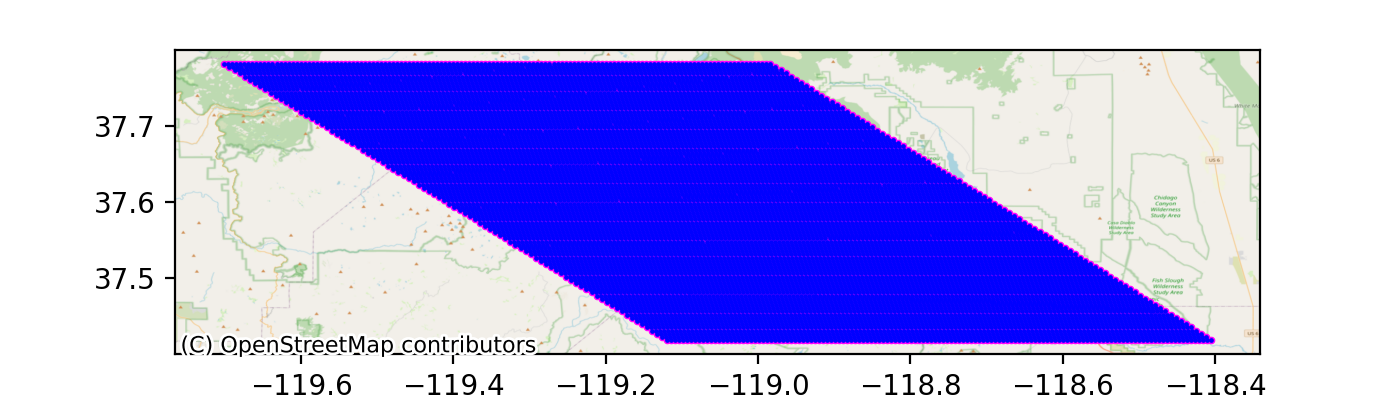

In [40]:
fig = plt.figure(figsize=(7, 2), dpi=200)
ax = fig.add_subplot()

pts = geopandas.points_from_xy(subset.lon, subset.lat)
subset.set_geometry(pts).plot(ax=ax, trixels=False, color='magenta', markersize=3, zorder=1)

df.set_geometry('centers_4326').plot(ax=ax, color='blue', markersize=0.5, zorder=2)
contextily.add_basemap(ax, crs=4326, source=contextily.providers.OpenStreetMap.Mapnik, zorder=0)